This notebook produces the d15N gradient that will be compared against the SST gradient in a separate notebook

Import required libraries and define the resampling function

In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import paleos.agemodel as pam
import paleos.common as pcm

from utils import get_source_d15N_data


def resample_series(series: pd.Series, new_idxs: np.ndarray) -> pd.Series:
    """Function to resample d15N data"""
    series = series.dropna().sort_index()
    no_duplicates = pcm.average_duplicated(series)
    return pam.resample_linear(no_duplicates, new_idxs)

Define paths and read in the input data

In [39]:

input_path = Path("data") / "input" / "d15N_A_P.csv"
output_path = Path("data") / "gradients" / (input_path.stem + "_gradient.csv")
if not output_path.parent.exists():
    output_path.parent.mkdir()
df = get_source_d15N_data()


Extract the data from the DataFrame into separate series, one for the Atlantic and one for the Pacific

- series 1 is Atlantic d15N data
- series 2 is Pacific d15N data

After extraction, resample them both on regular intervals and then calculate the gradient

In [40]:

output_ages = np.arange(0, 60, 0.30)
# series 1
series1 = pd.Series(data=df.iloc[:, 1].values, index=df.iloc[:, 0].values)
series1_resamp = resample_series(series1, output_ages)
# series 2
series2 = pd.Series(data=df.iloc[:, 3].values, index=df.iloc[:, 2].values)
series2_resamp = resample_series(series2, output_ages)
# the gradient
gradient_resamp = series2_resamp - series1_resamp


2022-07-15 14:00:22.698 | INFO     | paleos.common:average_duplicated:39 - Averaging values for duplicated indices
2022-07-15 14:00:22.709 | INFO     | paleos.common:average_duplicated:39 - Averaging values for duplicated indices


Save the gradient data so it can be used as a reference if required. There is a section without data for series 2 between 22.6Ma and 40Ma. This will be set to NaN before saving.

In [41]:

df_resampled = pd.DataFrame(
    data={
        "Atlantic": series1_resamp,
        "Pacific": series2_resamp,
        "Gradient": gradient_resamp,
    }
)
nan_start = 22.6
nan_end = 40
df_resampled.loc[nan_start:nan_end] = np.nan
df_resampled.to_csv(output_path)


Plot the d15N data and the gradient

ValueError: 'o' is not a valid value for color

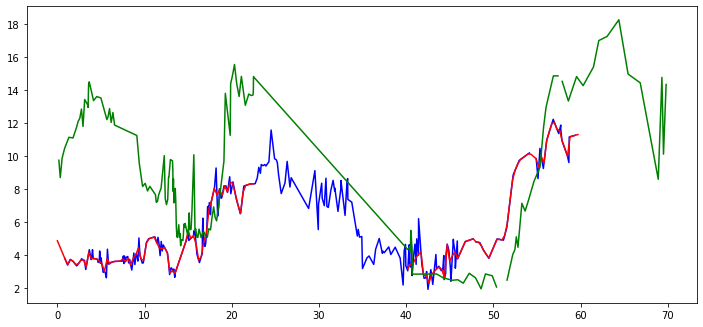

In [42]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
series1.plot(label="Atlantic", c="b")
df_resampled["Atlantic"].plot(label="Atlantic resampled", c="magenta")
series2.plot(label="Pacific", c="g")
df_resampled["Pacific"].plot(label="Pacific resampled", c="orange")
plt.xlabel("Age")
plt.ylabel("d15N")
plt.xlim(0, 75)
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_resampled["Gradient"])
plt.xlabel("Age")
plt.ylabel("d15N gradient")
plt.xlim(0, 75)
plt.show()